# Explore here

#### **Imports and Functions**

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from scipy.stats import randint

In [67]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score  
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
from wordcloud import WordCloud
from pickle import dump

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [68]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(n_estimators=20, random_state = 42)
xg = XGBClassifier(n_estimators=20, random_state = 42)
bernoulli = BernoulliNB()
svm = SVC(kernel = 'linear', random_state=42)
knn = KNeighborsClassifier(n_neighbors=2)

models = [lr, dt, rf, gb, xg, bernoulli, svm, knn]

In [14]:
#Pre processing text
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

#Lemmatizing the text in the url's
lemmatizer = WordNetLemmatizer()

download('stopwords')
stop_words = stopwords.words('english')

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### **Loading and analysing the data**

In [69]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv'
df = pd.read_csv(url)
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [71]:
#Checking for duplicates
df.duplicated().sum()

630

In [72]:
#Dropping duplicates
df = df.drop_duplicates()
df = df.reset_index(inplace=False, drop=True)
df.shape

(2369, 2)

In [73]:
#Checking for null values
df.isnull().sum()

url        0
is_spam    0
dtype: int64

#### **EDA**

In [74]:
df.is_spam.value_counts()

is_spam
False    2125
True      244
Name: count, dtype: int64

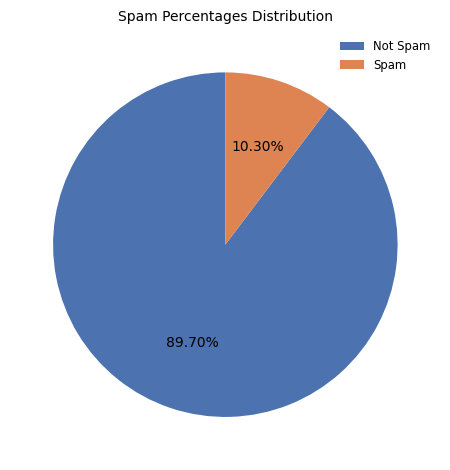

In [75]:
legend = ['Not Spam', 'Spam']
colours = sns.color_palette('deep')[0:len(legend)]
df.is_spam.value_counts().plot(kind='pie', autopct='%1.2f%%', startangle=90, colors=colours, labels=None)
plt.ylabel('')
plt.title('Spam Percentages Distribution', fontsize='medium')
plt.legend(legend, frameon=False, fontsize='small', loc='best')
plt.tight_layout()
plt.show()

The data is unbalanced, therefore we will use F1 Score to measure performance.

#### **Preparing the data to train the models**

In [76]:
df_model = df.copy()
df_model.is_spam = df_model.is_spam.astype(int)

In [77]:
df_model['url'] = df_model.url.apply(preprocess_text)
df_model['url'] = df_model['url'].apply(lemmatize_text)
df_model.head()

,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


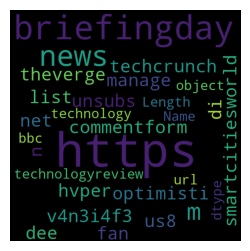

In [78]:
wordcloud = WordCloud(width=600, height=600, background_color="black", max_words=1000, min_font_size=20, random_state = 42).generate(str(df['url']))
fig = plt.figure(figsize=(3,3))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [79]:
#Transforming data into array
vector = TfidfVectorizer()

tokens = df_model.url.apply(lambda x: ' '.join(x))
X = vector.fit_transform(tokens).toarray()
y = df_model['is_spam']
X[:4]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [80]:
#Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train data:\nX:', X_train.shape, 'y:', y_train.shape)
print('Test data:\nX:', X_test.shape, 'y:', y_test.shape)

Train data:
X: (1895, 4687) y: (1895,)
Test data:
X: (474, 4687) y: (474,)


#### **Training the models**

Fitting LogisticRegression...
F1 Score on train data is 0.46
F1 Score on test data is 0.49

Fitting DecisionTreeClassifier...
F1 Score on train data is 0.98
F1 Score on test data is 0.67

Fitting RandomForestClassifier...
F1 Score on train data is 0.98
F1 Score on test data is 0.70

Fitting GradientBoostingClassifier...
F1 Score on train data is 0.44
F1 Score on test data is 0.52

Fitting XGBClassifier...
F1 Score on train data is 0.68
F1 Score on test data is 0.68

Fitting BernoulliNB...
F1 Score on train data is 0.19
F1 Score on test data is 0.10

Fitting SVC...
F1 Score on train data is 0.87
F1 Score on test data is 0.71

Fitting KNeighborsClassifier...
F1 Score on train data is 0.84
F1 Score on test data is 0.71



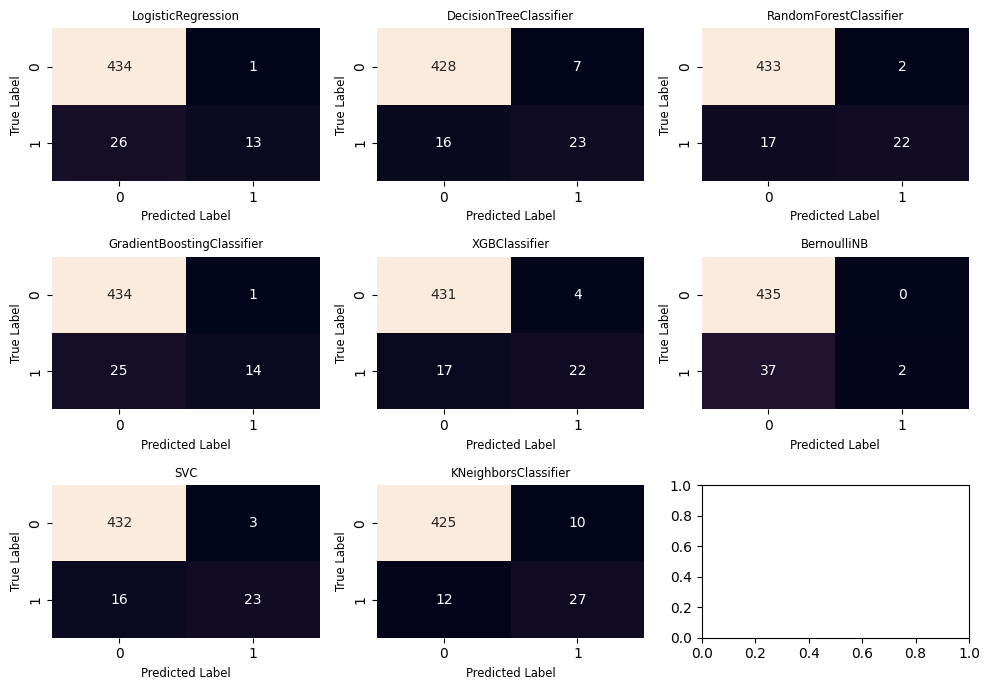

In [81]:
models_dict = []

# Determine the number of rows and columns for the grid
num_cols = 3
num_rows = 3

fig, axes = plt.subplots(3,3, figsize=(10, 7))

for i, model in enumerate(models):
    print(f'Fitting {model.__class__.__name__}...')
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    print(f'F1 Score on train data is {f1_train:.2f}')
    print(f'F1 Score on test data is {f1_test:.2f}\n')

    cm = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(cm)

    # Plot the confusion matrix in the grid
    sns.heatmap(cm_df, annot=True, fmt="d", cbar=False, ax=axes[i // num_cols, i % num_cols])
    axes[i // num_cols, i % num_cols].set_title(f'{model.__class__.__name__}', fontsize='small')
    axes[i // num_cols, i % num_cols].set_xlabel('Predicted Label', fontsize='small')
    axes[i // num_cols, i % num_cols].set_ylabel('True Label', fontsize='small')

    models_dict.append({'Model': model.__class__.__name__, 'F1 Score Train': f1_train, 'F1 Score Test': f1_test})
    
plt.tight_layout()
plt.show()

In [82]:
models_df = pd.DataFrame(models_dict)
models_df

,Model,F1 Score Train,F1 Score Test
0,LogisticRegression,0.456929,0.490566
1,DecisionTreeClassifier,0.975124,0.666667
2,RandomForestClassifier,0.975369,0.698413
3,GradientBoostingClassifier,0.435115,0.518519
4,XGBClassifier,0.679128,0.676923
5,BernoulliNB,0.185841,0.097561
6,SVC,0.870270,0.707692
7,KNeighborsClassifier,0.835227,0.710526


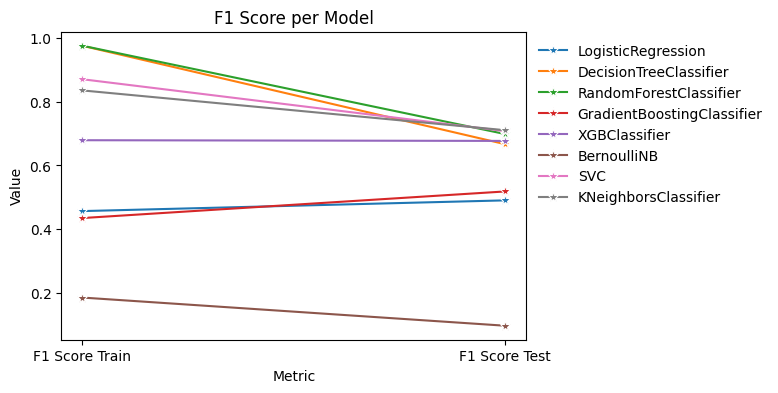

In [83]:
models_melted = pd.melt(models_df, id_vars=['Model'], var_name='Metric', value_name='Value')
plt.figure(figsize=(6,4))
sns.lineplot(x='Metric', y='Value', hue='Model', data=models_melted, marker='*', markersize=8)
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('F1 Score per Model')
plt.show()

##### Optimising SVC model

In [84]:
hyperparams = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [1,2,3,4,5],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

svm_op = RandomizedSearchCV(svm, hyperparams, scoring='f1_macro', cv=5, n_jobs=8, random_state=42)
svm_op

RandomizedSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
                   n_jobs=8,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=42, scoring='f1_macro')

In [85]:
svm_op.fit(X_train, y_train)
print("Best Hyperparameters:", svm_op.best_params_)

Best Hyperparameters: {'kernel': 'linear', 'gamma': 'scale', 'degree': 1, 'C': 1000}


In [86]:
svm_best = svm_op.best_estimator_
svm_best.fit(X_train, y_train)
y_pred_train = svm_best.predict(X_train)
y_pred_test = svm_best.predict(X_test)

In [87]:
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print(f'Acc Score on train data is {acc_train:.2f}')
print(f'Acc Score on test data is {acc_test:.2f}\n')

Acc Score on train data is 0.99
Acc Score on test data is 0.93



F1 Score on train data is 0.98
F1 Score on test data is 0.61



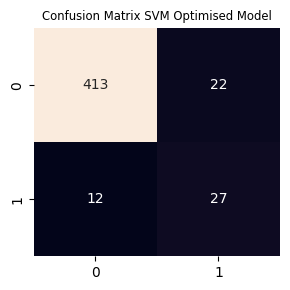

In [88]:
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
print(f'F1 Score on train data is {f1_train:.2f}')
print(f'F1 Score on test data is {f1_test:.2f}\n')

cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(3,3))
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)
plt.title('Confusion Matrix SVM Optimised Model', fontsize='small')
plt.tight_layout()
plt.show()

#### **Saving the model**

In [96]:
dump(svm, open("../models/svm_url_classifier.sav", "wb"))